# Avance de proyecto 2: Minería

### Para esta entrega, se trabajarán con los datos clasificados, para ver como se comportan los algoritmos aca usados y posteriormente generalizarlos en los datos sin clasificar.

## 1) Carga de librerias y conjunto de datos

In [1]:
import json
import csv
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
with open('ICMLA.json') as file:
  data2=json.load(file)

In [3]:
df2=pd.DataFrame.from_dict(json_normalize(data2))
df2.head(5)

,paper_id,title,keywords,abstract,session,year
0,1,Ensemble Statistical and Heuristic Models for ...,"statistical word alignment, ensemble learning,...",Statistical word alignment models need large a...,Ensemble Methods,2014
1,2,Improving Spectral Learning by Using Multiple ...,"representation, spectral learning, discrete fo...",Spectral learning algorithms learn an unknown ...,Ensemble Methods,2014
2,3,Applying Swarm Ensemble Clustering Technique f...,"software defect prediction, particle swarm opt...",Number of defects remaining in a system provid...,Ensemble Methods,2014
3,4,Reducing the Effects of Detrimental Instances,"filtering, label noise, instance weighting",Not all instances in a data set are equally be...,Ensemble Methods,2014
4,5,Concept Drift Awareness in Twitter Streams,"twitter, adaptation models, time-frequency ana...",Learning in non-stationary environments is not...,Ensemble Methods,2014


## 2) Preprocesamiento y limpieza de los datos

In [4]:
clase = pd.DataFrame(df2['session'].value_counts())
for j in range(0,83):
  for i in range(0,448):
    if df2['session'][i]==clase.index[j]:
      df2['session'][i]=j
df2.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,paper_id,title,keywords,abstract,session,year
0,1,Ensemble Statistical and Heuristic Models for ...,"statistical word alignment, ensemble learning,...",Statistical word alignment models need large a...,8,2014
1,2,Improving Spectral Learning by Using Multiple ...,"representation, spectral learning, discrete fo...",Spectral learning algorithms learn an unknown ...,8,2014
2,3,Applying Swarm Ensemble Clustering Technique f...,"software defect prediction, particle swarm opt...",Number of defects remaining in a system provid...,8,2014
3,4,Reducing the Effects of Detrimental Instances,"filtering, label noise, instance weighting",Not all instances in a data set are equally be...,8,2014
4,5,Concept Drift Awareness in Twitter Streams,"twitter, adaptation models, time-frequency ana...",Learning in non-stationary environments is not...,8,2014


### a) Descripción de los datos

In [5]:
df2.shape

(448, 6)

In [6]:
## porcentaje de datos faltantes por columna en df2
df2.isnull().mean().sort_values(ascending=False)

year        0.0
session     0.0
abstract    0.0
keywords    0.0
title       0.0
paper_id    0.0
dtype: float64

In [7]:
df2.dtypes

paper_id     int64
title       object
keywords    object
abstract    object
session     object
year         int64
dtype: object

In [8]:

df2['year']=df2['abstract'].apply(len)
df2.rename(columns={'year':'abstract_length'},inplace=True)
df2.describe()

,paper_id,abstract_length
count,448.000000,448.000000
mean,224.500000,1047.102679
std,129.470717,310.815336
min,1.000000,360.000000
25%,112.750000,819.250000
50%,224.500000,985.500000
75%,336.250000,1237.500000
max,448.000000,2008.000000


Se eliminan aquellos objetos que superen una cantidad determinada de palabras en sus abstract, esto debido a la complejidad que generan dentro del análisis.

In [9]:

index=[]
for i in range(0,448):
  if df2['abstract_length'][i]> 1400:
    index.append(i)
df2=df2.drop(index,axis=0)
df2.shape

(382, 6)

In [10]:
df2['abstract']

0      Statistical word alignment models need large a...
1      Spectral learning algorithms learn an unknown ...
2      Number of defects remaining in a system provid...
3      Not all instances in a data set are equally be...
4      Learning in non-stationary environments is not...
                             ...                        
440    Big Data has been a catalyst force for the Mac...
441    Recently emerging software applications are la...
443    In the current era of big data, high volumes o...
445    We apply cluster analysis to a sample of 2,116...
447    Bayesian nonparametric (BNP) statistical techn...
Name: abstract, Length: 382, dtype: object

Se eliminan las puntuaciones de los abstract:

In [0]:
def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

In [12]:
df2['abstract'] = df2['abstract'].apply(lambda x: remove_punctuation(x))
abstr=df2['abstract']
abstr.head(5)

0    Statistical word alignment models need large a...
1    Spectral learning algorithms learn an unknown ...
2    Number of defects remaining in a system provid...
3    Not all instances in a data set are equally be...
4    Learning in nonstationary environments is not ...
Name: abstract, dtype: object

A continuación, se tokenizan los abstract de tal manera que únicamente se trabaje para anaizar palabra por palabra que lo conforma.

In [0]:
tokenizer = RegexpTokenizer(r'\w+')

In [14]:
abstr = abstr.apply(lambda x: tokenizer.tokenize(x.lower()))
token=abstr
abstr.head(5)

0    [statistical, word, alignment, models, need, l...
1    [spectral, learning, algorithms, learn, an, un...
2    [number, of, defects, remaining, in, a, system...
3    [not, all, instances, in, a, data, set, are, e...
4    [learning, in, nonstationary, environments, is...
Name: abstract, dtype: object

Se eliminan aquellas palabras que no son trascendentes en los textos pero que aparecen con bastante frecuencia, denominadas las stopwords.

In [0]:
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

In [16]:
nltk.download('stopwords')
abstr=abstr.apply(lambda x: remove_stopwords(x))
abstr.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [statistical, word, alignment, models, need, l...
1    [spectral, learning, algorithms, learn, unknow...
2    [number, defects, remaining, system, provides,...
3    [instances, data, set, equally, beneficial, in...
4    [learning, nonstationary, environments, easy, ...
5    [work, presents, new, method, classifying, pre...
6    [captchas, challengeresponse, tests, widely, u...
7    [reinforcement, learning, techniques, become, ...
8    [signatures, single, widely, used, method, ide...
9    [automatic, detection, abnormal, events, one, ...
Name: abstract, dtype: object

Se itemiza los vectores para poder trabajar las palabras en su forma mas sencilla (sin plurales ni gerundios)

In [0]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
  lem_text = [lemmatizer.lemmatize(i) for i in text]
  return lem_text

In [18]:
abstr.apply(lambda x: word_lemmatizer(x)).head(10)

0    [statistical, word, alignment, model, need, la...
1    [spectral, learning, algorithm, learn, unknown...
2    [number, defect, remaining, system, provides, ...
3    [instance, data, set, equally, beneficial, ind...
4    [learning, nonstationary, environment, easy, t...
5    [work, present, new, method, classifying, prev...
6    [captchas, challengeresponse, test, widely, us...
7    [reinforcement, learning, technique, become, p...
8    [signature, single, widely, used, method, iden...
9    [automatic, detection, abnormal, event, one, c...
Name: abstract, dtype: object

Stemming hace referencia a dejar las palabras en su núcleo mas sencillo de tal manera que se puedan asociar aquellas que hagan referencia a lo mismo.

In [0]:
stemmer = PorterStemmer()

In [0]:
def word_stemmer(text):
  stem_text = " ".join([stemmer.stem(i) for i in text])
  return stem_text

In [21]:
abstr=abstr.apply(lambda x: word_stemmer(x))
stem=abstr
abstr

0      statist word align model need larg amount trai...
1      spectral learn algorithm learn unknown functio...
2      number defect remain system provid insight qua...
3      instanc data set equal benefici induc model da...
4      learn nonstationari environ easi task requir d...
                             ...                        
440    big data catalyst forc machin learn ml area fo...
441    recent emerg softwar applic larg complex distr...
443    current era big data high volum wide varieti d...
445    appli cluster analysi sampl 2116 children auti...
447    bayesian nonparametr bnp statist techniqu thri...
Name: abstract, Length: 382, dtype: object

Se listan esas palabras núcleo que mas se repiten en todos los documentos;

In [22]:
#Identify common words
freq = pd.Series(' '.join(abstr).split()).value_counts()[:20]
freq

use          573
data         462
learn        425
algorithm    350
model        347
propos       333
method       318
result       258
paper        256
network      238
base         224
perform      221
approach     216
system       203
featur       199
predict      189
classif      171
machin       163
train        161
techniqu     160
dtype: int64

In [23]:
freq.describe()

count     20.00000
mean     273.35000
std      112.66965
min      160.00000
25%      196.50000
50%      231.00000
75%      336.50000
max      573.00000
dtype: float64

Se muestra una nube de palabras que refleja aquellas que más frecuencia tienen:

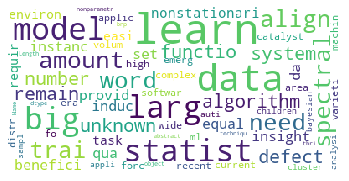

In [24]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(abstr))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

En total, hay 3944 palabras diferentes en todos los textos, como se muestra a continuación:

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(token_pattern=r'\b[^\d\W]+\b') 
X = count_vect.fit_transform(abstr)
len(count_vect.get_feature_names())


3944

## 3) Asociación

In [26]:
def Convert(string): 
    li = list(string.split(" ")) 
    return li 

matriz=abstr.as_matrix()
abstr_matr=[]
for i in range(0,len(abstr)):
  abstr_matr.append(np.array(Convert(matriz[i])))
dfabstr=pd.DataFrame(abstr_matr,df2['session'])
dfabstr.head(5)
             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,statist,word,align,model,need,larg,amount,train,data,weak,smallsiz,corpora,paper,propos,new,approach,unsupervis,hybrid,word,align,techniqu,use,ensembl,learn,method,algorithm,use,three,base,align,model,sever,round,gener,align,ensembl,algorithm,use,weigh,scheme,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,spectral,learn,algorithm,learn,unknown,function,learn,spectral,eg,fourier,represent,function,howev,mani,possibl,spectral,represent,none,best,situat,consequ,seem,natur,consid,spectral,learner,could,make,use,multipl,represent,learn,paper,propos,compar,three,approach,learn,multipl,spectral,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,number,defect,remain,system,provid,insight,qualiti,system,defect,detect,system,predict,defect,use,softwar,metric,data,mine,techniqu,cluster,analysi,adopt,build,softwar,defect,predict,model,cluster,ensembl,emerg,promin,method,improv,robust,stabil,accuraci,cluster,solut,cluster,ensembl,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,instanc,data,set,equal,benefici,induc,model,data,instanc,outlier,nois,detriment,howev,least,initi,instanc,data,set,gener,consid,equal,machin,learn,algorithm,mani,current,approach,handl,noisi,detriment,instanc,make,binari,decis,whether,instanc,detriment,paper,1,extend,...,result,also,suggest,accur,estim,instanc,detriment,signific,posit,impact,handl,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,learn,nonstationari,environ,easi,task,requir,distinct,approach,learn,model,must,abil,continu,learn,also,abil,chang,alreadi,acquir,concept,addit,given,signific,import,social,network,gain,inform,network,evergrow,interest,extract,complex,inform,use,trend,detect,promot,servic,market,...,learn,presenc,drift,along,classifi,messag,twitter,stream,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


### a) Algorítmo Apriori

In [0]:
records = []
for i in range(0, len(df2['abstract'])):
    records.append([str(dfabstr.values[i,j]) for j in range(0, 20)])

In [28]:
!pip install apyori

In [0]:
from apyori import apriori

association_rules = apriori(records, min_support=0.08, min_confidence=0.4, min_length=2)
association_results = list(association_rules)

A continuación se muestran las reglas obtenidas:

In [30]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: machin -> learn
Support: 0.0968586387434555
Confidence: 0.5362318840579711
Lift: 4.996111700247438


### b) Algorítmo FPgrowth

In [31]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(abstr_matr).transform(abstr_matr)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.tail(7)

,00003,004,005,006,031m,034,05,061,074,076,077,078,082,0901,095,097,1,10,100,101,1022,104,106,108,109,11,12,120,123bu,128,13,133,14,143,14410,15,153,153600,16,160,...,wireless,within,without,wma,women,word,wordlist,work,worker,workfre,workload,world,worldwid,worst,worth,worthwhil,worthwhilein,would,wrap,wrapper,wristworn,write,written,wrote,wsn,wwwdatagrapplecom,wyom,x,xgboost,xor,xray,yale,year,yearli,yet,yield,yornois,youtub,zero,zeroshot
375,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
376,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
377,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
378,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
379,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
380,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
381,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [32]:
!pip install arff

In [33]:
!pip install mlxtend
!pip install fpgrowth
!pip install git+git://github.com/rasbt/mlxtend.git

  Cloning git://github.com/rasbt/mlxtend.git to /tmp/pip-req-build-y3v2hsww
  Running command git clone -q git://github.com/rasbt/mlxtend.git /tmp/pip-req-build-y3v2hsww
  Created wheel for mlxtend: filename=mlxtend-0.18.0.dev0-py2.py3-none-any.whl size=1575237 sha256=882ee0c1581246addae800a23c9a7ac93fcd1524cb164c32607607908450c5b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmmiqrft/wheels/85/e4/4c/ee71547ac9ea223b07fe8f55b0e5f71536a6a34ae3480205f3
Successfully built mlxtend


A continuación se muestran las reglas obtenidas:

In [34]:
from mlxtend.frequent_patterns import fpgrowth

fpgrowth(df, min_support=0.3,max_len=4, use_colnames=True)

,support,itemsets
0,0.746073,(use)
1,0.617801,(paper)
2,0.536649,(result)
3,0.526178,(data)
4,0.505236,(propos)
5,0.494764,(learn)
6,0.421466,(model)
7,0.421466,(algorithm)
8,0.408377,(method)
9,0.397906,(base)


## 4) Agrupación (Realizado en WEKA)

In [0]:
freq1 =  pd.Series(' '.join(abstr).split()).value_counts()[-3750:]
toremove=[]
for i in range(0,3750):
  toremove.append(freq1.index[i])


In [0]:
dfweka1=df.drop(toremove,axis=1)

In [37]:
dfweka1.head()

,1,2,abil,abl,accur,accuraci,achiev,action,activ,adapt,addit,address,advantag,aim,algorithm,allow,also,amount,analysi,analyz,anomali,appli,applic,approach,approxim,area,associ,attack,attribut,audio,autom,automat,avail,averag,base,bay,becom,behavior,best,better,...,tempor,term,test,text,therefor,three,thu,time,tool,topic,track,tradit,traffic,train,transfer,two,type,typic,understand,unsupervis,use,user,util,valid,valu,vari,variou,vector,vehicl,video,visual,way,web,weight,well,wide,word,work,world,year
0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
dfweka1.to_csv('example6.csv')

In [39]:
df2['session'].value_counts()

0                                                  17
1                                                  16
2                                                  15
3                                                  10
5                                                   9
                                                   ..
Formal Modeling for Machine Learning Techniques     1
69                                                  1
75                                                  1
55                                                  1
Graphs Methods                                      1
Name: session, Length: 86, dtype: int64